In [93]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In [94]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

In [95]:
boston = load_boston()


# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

In [96]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [97]:
prefix = 'boston-xgboost-HL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [98]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [107]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [108]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-08 01:39:10 Starting - Starting the training job...
2020-09-08 01:39:12 Starting - Launching requested ML instances......
2020-09-08 01:40:18 Starting - Preparing the instances for training.........
2020-09-08 01:42:06 Downloading - Downloading input data
2020-09-08 01:42:06 Training - Downloading the training image...
2020-09-08 01:42:37 Uploading - Uploading generated training model
2020-09-08 01:42:37 Completed - Training job completed
Arguments: train
[2020-09-08:01:42:25:INFO] Running standalone xgboost training.
[2020-09-08:01:42:25:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8477.44mb
[2020-09-08:01:42:25:INFO] Determined delimiter of CSV input is ','
[01:42:25] S3DistributionType set as FullyReplicated
[01:42:25] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-09-08:01:42:25:INFO] Determined delimiter of CSV input is ','
[01:42:25] S3DistributionType set as 

In [109]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


...........................
.2020-09-08T01:47:20.308:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
Arguments: serve
[2020-09-08 01:47:20 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-09-08 01:47:20 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-09-08 01:47:20 +0000] [1] [INFO] Using worker: gevent
[2020-09-08 01:47:20 +0000] [36] [INFO] Booting worker with pid: 36
[2020-09-08 01:47:20 +0000] [37] [INFO] Booting worker with pid: 37
[2020-09-08:01:47:20:INFO] Model loaded successfully for worker : 36
[2020-09-08:01:47:20:INFO] Model loaded successfully for worker : 37
[2020-09-08 01:47:20 +0000] [38] [INFO] Booting worker with pid: 38
[2020-09-08:01:47:20:INFO] Sniff delimiter as ','
[2020-09-08:01:47:20:INFO] Determined delimiter of CSV input is ','
[2020-09-08 01:47:20 +0000] [39] [INFO] Booting worker with pid: 39
[2020-09-08:01:47:20:INFO] Model loaded successfully for worker : 38
[2020-09-08:01:47:20:INFO

In [110]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-2-360760555806/xgboost-2020-09-08-01-42-52-821/test.csv.out to ../data/boston/test.csv.out


Text(0.5, 1.0, 'Median Price vs Predicted Price')

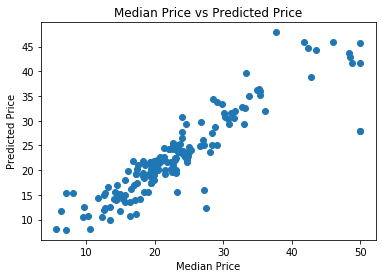

In [111]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

In [125]:
Y_pred

,0
0,21.554785
1,24.695351
2,8.190662
3,23.943108
4,11.681423
...,...
162,17.313929
163,25.202507
164,25.052204
165,21.000025


In [131]:
df = Y_test.rename(columns={'newName1': 'test'}).reset_index(drop=True)

df["predict"] = Y_pred

df

,test,predict
0,21.8,21.554785
1,25.0,24.695351
2,5.6,8.190662
3,23.7,23.943108
4,6.3,11.681423
...,...,...
162,19.5,17.313929
163,23.6,25.202507
164,27.1,25.052204
165,19.4,21.000025


In [135]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(Y_test, Y_pred))

rms

4.006323570693154

In [136]:
from sklearn.metrics import mean_absolute_error as MAE

mae_result = MAE(Y_test, Y_pred)

mae_result

2.521275581995509

In [138]:
from sklearn.metrics import r2_score

scipy_value = r2_score(Y_test, Y_pred)

scipy_value

0.8091997151434214

In [139]:
import numpy

y = [1, 2, 3, 4, 5]
f = [1.9, 3.7, 5.8, 8.0, 9.6]

# Convert to numpy array and ensure double precision to avoid single precision errors
observed = numpy.array(y, dtype=numpy.float64)
predicted = numpy.array(f, dtype=numpy.float64)

observed

array([1., 2., 3., 4., 5.])

In [140]:
y

[1, 2, 3, 4, 5]

In [143]:
df["test"]

0      21.8
1      25.0
2       5.6
3      23.7
4       6.3
       ... 
162    19.5
163    23.6
164    27.1
165    19.4
166    16.1
Name: test, Length: 167, dtype: float64